---
        Imports
---

In [78]:
import re
from datetime import date

import requests #web requests from ZoteroAPI
import pandas as pd #data handling
from fuzzywuzzy import fuzz #fuzzy string matching
import matplotlib.pyplot as plt #plotting

---
        Config
---

- Read more about the [ZoteroAPI](https://www.zotero.org/support/dev/web_api/v3/start)
- Get your [Zotero API Key](https://www.zotero.org/settings/keys) - find your UserID at the top of the page
- Get your collectionID at `<api-url>/users/<user-id>/collections`
- Set the values for
  - `FUZZY_THRESHOLD`: the threshold for the fuzzy string matching of tags using [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance)
  - `OCCURENCE_CUTOFF`: the cutoff for # of occurences in the tag groups

In [126]:
ZOTERO_API_KEY = input("Enter your Zotero API Key: ")
ZOTERO_USER_ID = input("Enter your Zotero User ID: ")
ZOTERO_COLLECTION_ID = input("Enter your Zotero Collection ID: ")

FUZZY_THRESHOLD = 90
OCCURENCE_CUTOFF = 2

---
         Load the data
---

**IMPORTANT:** the limit is currently set to 100 (see `url`)

In [ ]:
url = f"https://api.zotero.org/users/{ZOTERO_USER_ID}/collections/{ZOTERO_COLLECTION_ID}/items?limit=100&format=json&key={ZOTERO_API_KEY}"
response = requests.get(url)

if response.status_code == 200:
  citations = response.json()
else:
  print("Error: ", response.status_code)

# Filter the citation_data list and remove attachments and notes
filtered_citation_data = [data for data in citations if data['data'].get('itemType') not in ['attachment', 'note']]

# Create a DataFrame from the filtered_citation_data
df = pd.DataFrame(filtered_citation_data)

print(df.to_markdown())

---
        Plot: Number of publications per year
---

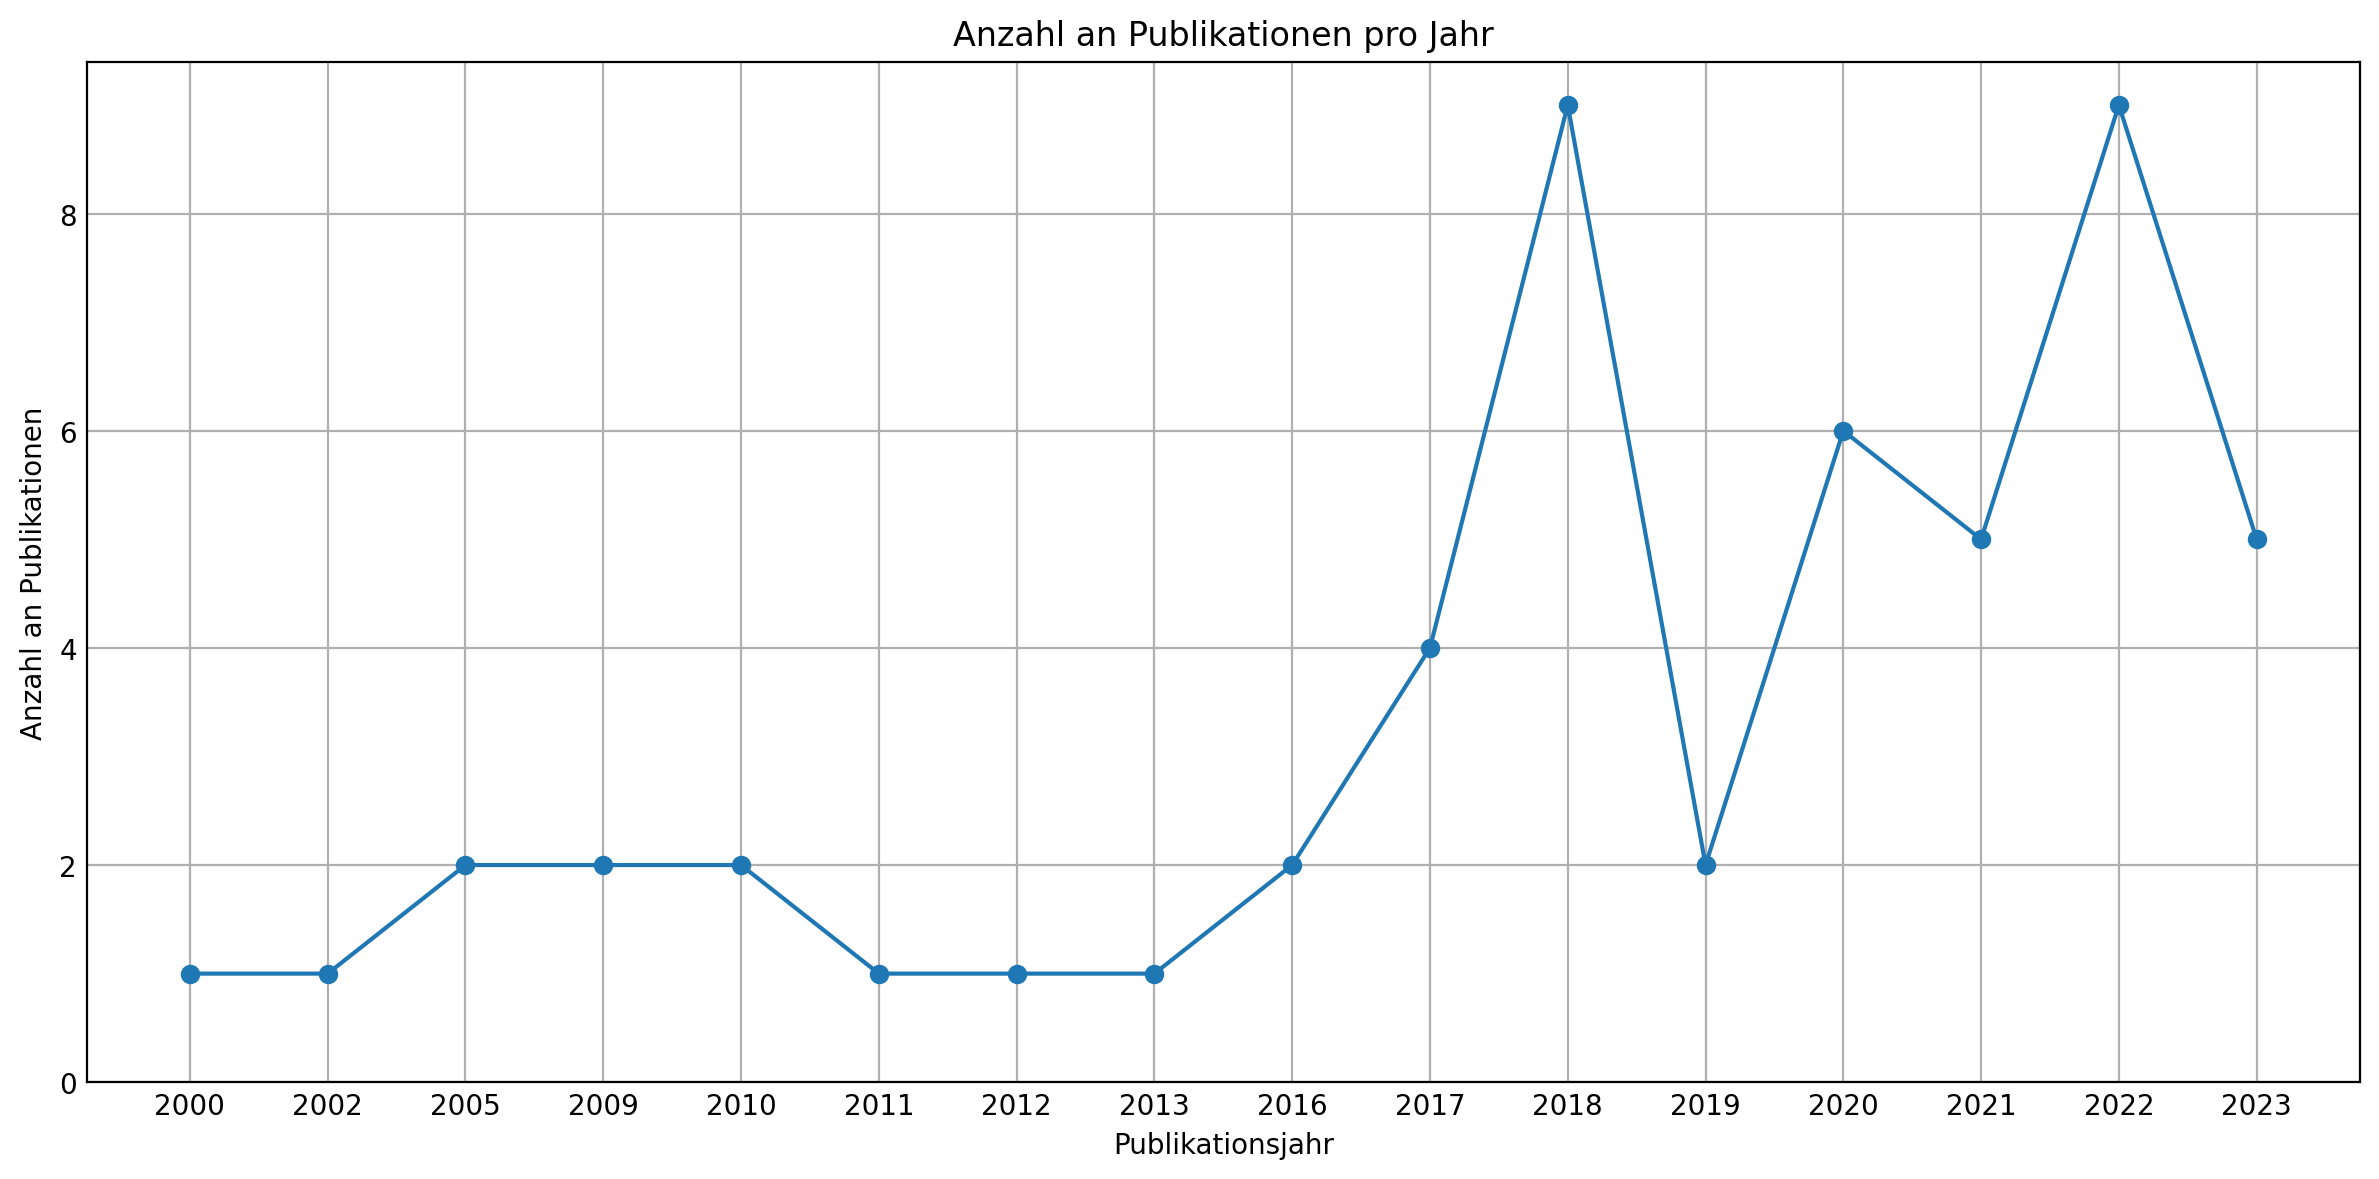

In [114]:
# Count the occurrences of each year
parsedYears = df['meta'].apply(lambda x: x['parsedDate'][:4])
year_counts = parsedYears.value_counts().sort_index()

# Prepare the plot size
plt.figure(figsize=(12, 6))
plt.rcParams['figure.dpi'] = 200

plt.plot(year_counts.index, year_counts.values, 'o-')

plt.xlabel('Publikationsjahr')
plt.ylabel('Anzahl an Publikationen')
plt.title('Anzahl an Publikationen pro Jahr')

# Set the y-axis limit to start at 0
plt.ylim(0)

# Adjust the layout to include labels
plt.tight_layout()

# Save the plot as a PDF file
today = date.today().strftime("%Y-%m-%d")
plot_name = f'publication_years-{today}'
plt.savefig(f'{plot_name}.pdf', format='pdf')



---
        Plot: Most common tags
---

**IMPORTANT:** in the first line of the main code every tag starting with 'round' is removed because it was used for manual tagging according to hermeneutic literature research in my collection and would distort the results

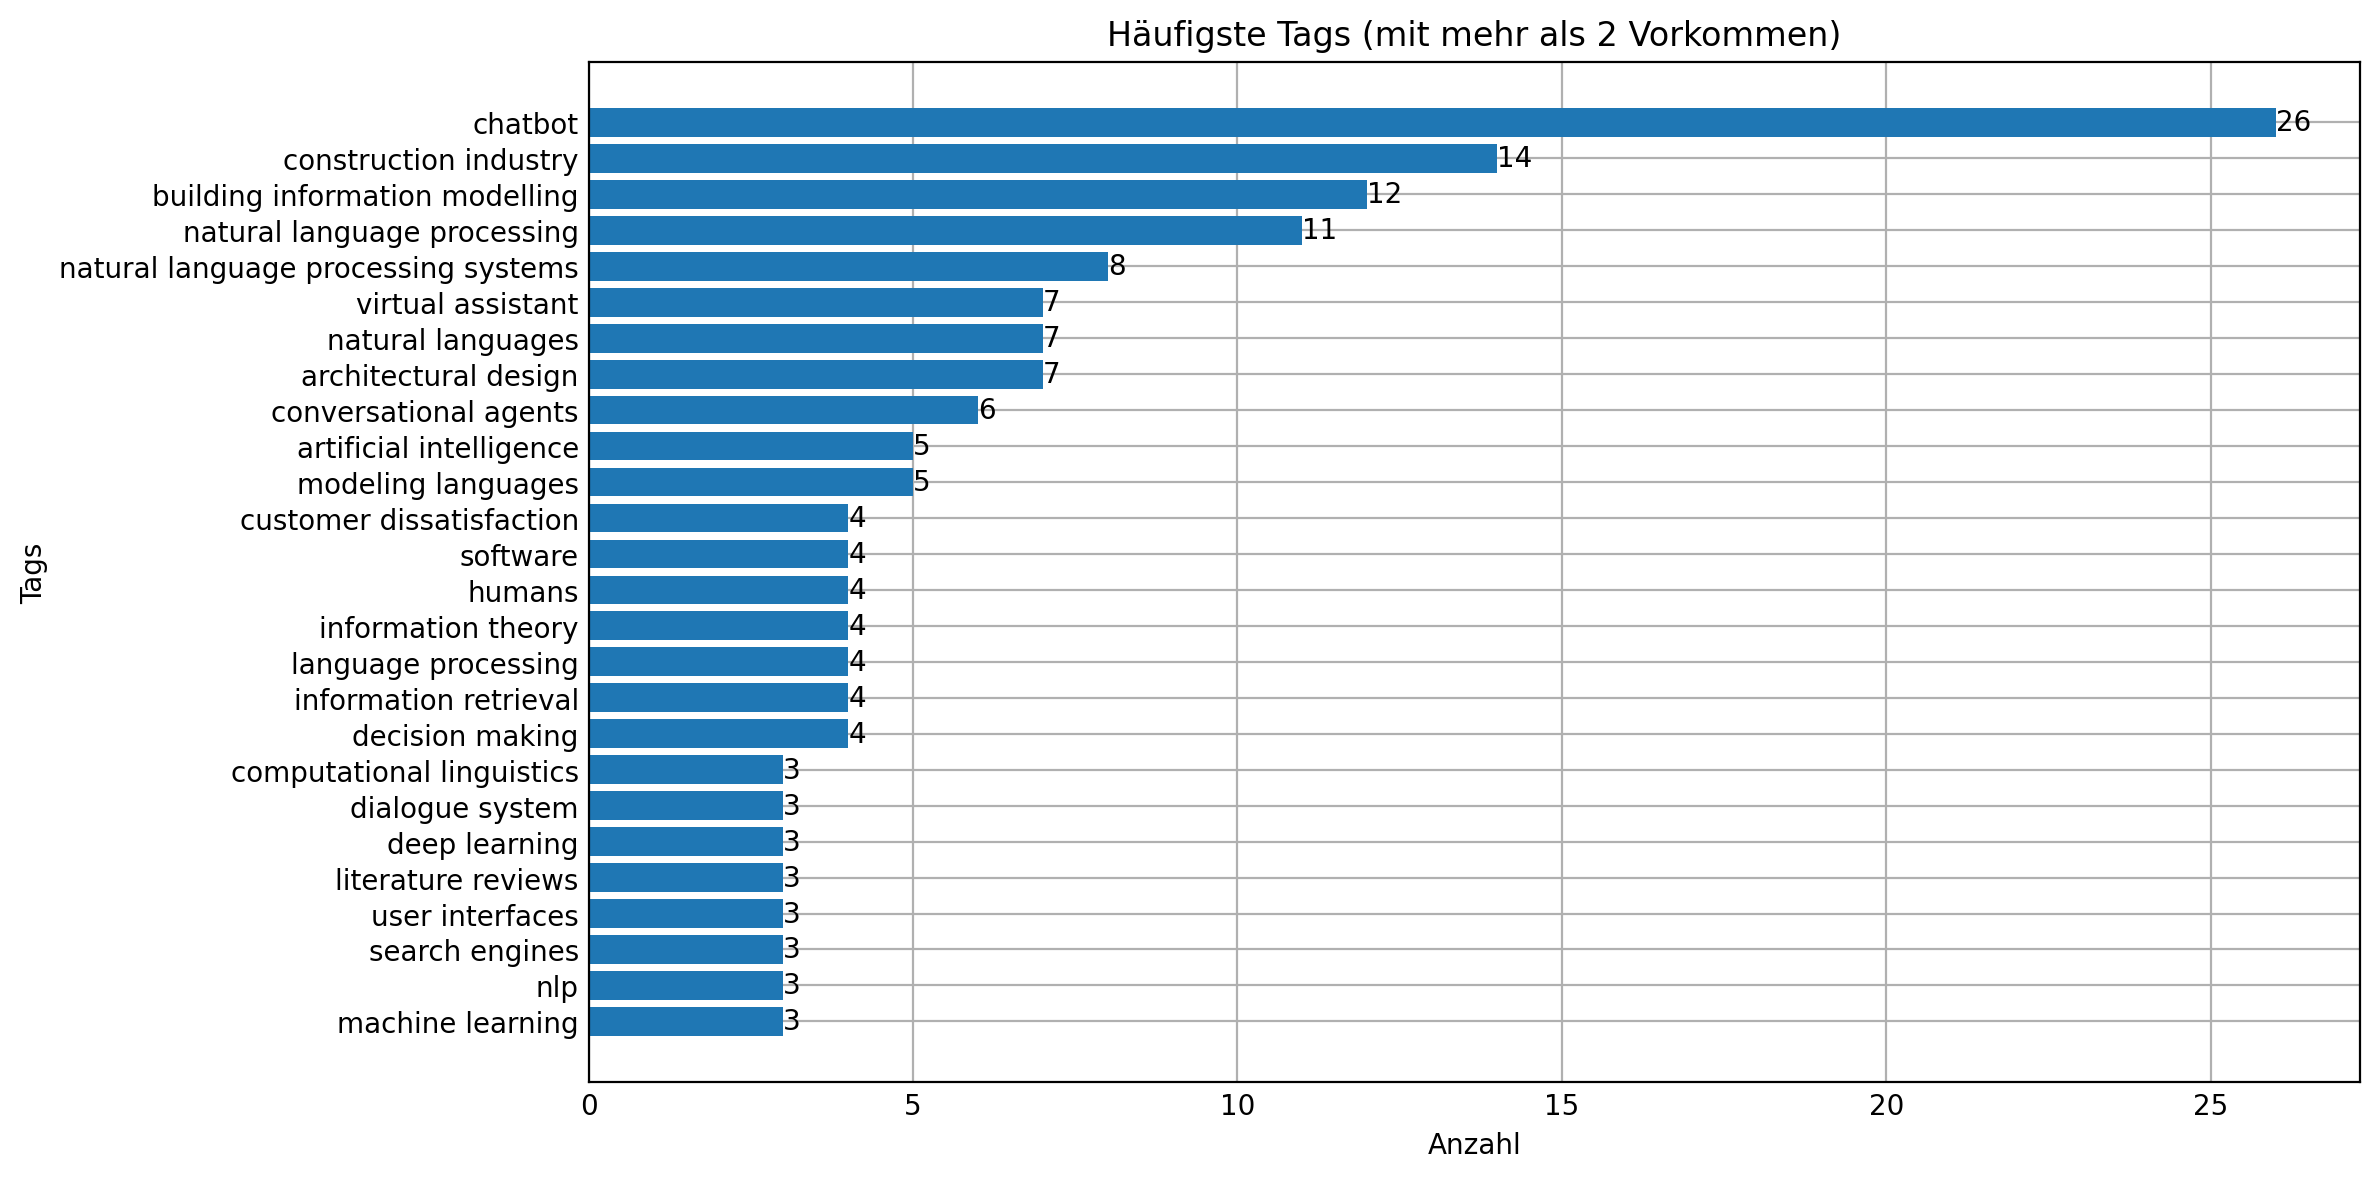

In [125]:
# Tag normalization - cuts out parentheses (e.g. '(bim)') and converts to lowercase
def normalize_tag(tag):
  tag = re.sub(r'\(.*\)', '', tag)
  return tag.lower().strip()

# Tag grouping using fuzzy string matching
def group_similar_tags(tags, threshold=90):
  groups = []
  for tag in tags:
      for group in groups:
          if fuzz.ratio(group[0], tag) > threshold:
              group.append(tag)
              break
      else:
          groups.append([tag])
  return groups

# Normalize and group
normalized_tags = [normalize_tag(tag['tag']) for tags in df['data'].apply(lambda x: x['tags']).tolist() for tag in tags if not tag['tag'].startswith('round')]
tag_groups = group_similar_tags(normalized_tags, FUZZY_THRESHOLD)

# Count group size and sort (also: pick the representative out of the groups)
tag_counts = {group[0]: len(group) for group in tag_groups}
most_common_tags = sorted(tag_counts.items(), key=lambda item: item[1])

# Prepare the plot size
plt.figure(figsize=(12, 6))
plt.rcParams['figure.dpi'] = 200

# Filter the tags and counts with more than OCCURENCE_CUTOFF occurrences
filtered_tags, filtered_counts = zip(*[(tag, count) for tag, count in most_common_tags if count > OCCURENCE_CUTOFF])

plt.barh(filtered_tags, filtered_counts)

plt.xlabel('Anzahl')
plt.ylabel('Tags')
plt.title(f'Häufigste Tags (mit mehr als {OCCURENCE_CUTOFF} Vorkommen)')

for i, count in enumerate(filtered_counts):
  plt.text(count, i, str(count), ha='left', va='center')

# Adjust the layout to include labels
plt.tight_layout()

# Save the plot as a PDF file
today = date.today().strftime("%Y-%m-%d")
plot_name = f'common_tags-{today}'
plt.savefig(f'{plot_name}.pdf', format='pdf')
